### https://www.census.gov/data/developers/data-sets.html

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import os
from urllib.request import urlopen
import json
import requests
import seaborn as sns

path=os.getcwd()

In [2]:
bse='S0101_C01_001E'
gp=['state','zip code tabulation area']

In [3]:
vbles=pd.read_csv(path+'/kmeans_variables2.csv')

### Get data

#### imputation

In [4]:
raw=pd.read_csv(path+'/02_raw.csv')
raw.shape

(33120, 105)

In [5]:
total_pop=raw[bse].sum()
total_pop

327998752

In [6]:
raw=raw[raw[bse]>=2000]
raw.shape

(18602, 105)

In [7]:
18602/33120

0.5616545893719807

In [8]:
print(raw[bse].sum())
print(raw[bse].sum().astype(float)/total_pop)

317662988
0.9684884044924659


In [9]:
num_cols=[x for x in list(raw.columns) if x not in [bse]+gp]

zp=raw[gp+[bse]]
dta=raw[num_cols]
dta=np.array(dta)

In [10]:
dta.shape

(18602, 102)

In [11]:
df=raw[num_cols].describe()
df.T

,count,mean,std,min,25%,50%,75%,max
S0102_C01_061E,2906.0,0.001165,0.000504,0.000250,0.000813,0.001079,0.001413,0.004846
S0102_C01_065E,2906.0,0.000206,0.000202,0.000005,0.000070,0.000141,0.000267,0.001952
S1601_C01_004E,18602.0,0.087538,0.146108,0.000000,0.011476,0.031589,0.090275,0.987302
S1601_C01_012E,18602.0,0.020090,0.043235,0.000000,0.001033,0.006149,0.019461,0.590121
S0101_C03_001E,18602.0,0.496556,0.038870,0.017529,0.478886,0.492480,0.507765,1.000000
...,...,...,...,...,...,...,...,...
S0101_C05_015E,18602.0,0.029464,0.011764,0.000000,0.022245,0.028341,0.035003,0.127127
S0101_C05_016E,18602.0,0.022913,0.010769,0.000000,0.016228,0.021572,0.027650,0.151608
S0101_C05_017E,18602.0,0.016534,0.008818,0.000000,0.010899,0.015371,0.020606,0.143477
S0101_C05_018E,18602.0,0.011635,0.006867,0.000000,0.007064,0.010724,0.015033,0.074254


#### don't need impute with sophisticated ways 
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)
imp.fit(dta)
dta_imputed = imp.transform(dta)

In [12]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(dta)
dta_imputed=imp.transform(dta)

In [13]:
tmp=pd.DataFrame(dta_imputed, columns=num_cols)

In [14]:
df=tmp.describe().T.reset_index()
df[:3]

,index,count,mean,std,min,25%,50%,75%,max
0,S0102_C01_061E,18602.0,0.001165,0.000199,0.000250,0.001165,0.001165,0.001165,0.004846
1,S0102_C01_065E,18602.0,0.000206,0.000080,0.000005,0.000206,0.000206,0.000206,0.001952
2,S1601_C01_004E,18602.0,0.087538,0.146108,0.000000,0.011476,0.031589,0.090275,0.987302


In [15]:
df[df['count']!=18602]

,index,count,mean,std,min,25%,50%,75%,max


## run the model
### https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [16]:
raw_array=dta_imputed

In [17]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
scaler.fit(raw_array)
raw_array=scaler.transform(raw_array)
raw_array.shape

(18602, 102)

In [18]:
mdl_input_scaled=pd.concat([zp.reset_index(drop=True), pd.DataFrame(raw_array,columns=num_cols).reset_index(drop=True)],axis=1, ignore_index=True)
mdl_input_scaled[:3]

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,54,25303,6764,0.199199,0.103082,0.008535,0.025053,0.477536,0.233137,0.277398,...,0.215049,0.282535,0.260543,0.252556,0.283118,0.227936,0.224286,0.110255,0.075659,0.071143
1,54,25311,10964,0.199199,0.103082,0.007206,0.007573,0.479382,0.296802,0.314016,...,0.251637,0.285744,0.248481,0.283289,0.368660,0.186537,0.096256,0.082005,0.153540,0.173504
2,54,25419,11062,0.199199,0.103082,0.011628,0.021140,0.501753,0.398823,0.242427,...,0.110505,0.467300,0.397896,0.205125,0.160562,0.379013,0.146087,0.101440,0.121744,0.042822


In [19]:
df=pd.DataFrame(raw_array,columns=num_cols).describe().T.reset_index()
df

,index,count,mean,std,min,25%,50%,75%,max
0,S0102_C01_061E,18602.0,0.199199,0.043301,0.0,0.199199,0.199199,0.199199,1.0
1,S0102_C01_065E,18602.0,0.103082,0.041058,0.0,0.103082,0.103082,0.103082,1.0
2,S1601_C01_004E,18602.0,0.088664,0.147987,0.0,0.011624,0.031996,0.091436,1.0
3,S1601_C01_012E,18602.0,0.034044,0.073265,0.0,0.001750,0.010420,0.032978,1.0
4,S0101_C03_001E,18602.0,0.487574,0.039564,0.0,0.469589,0.483425,0.498983,1.0
...,...,...,...,...,...,...,...,...,...
97,S0101_C05_015E,18602.0,0.231768,0.092533,0.0,0.174981,0.222936,0.275339,1.0
98,S0101_C05_016E,18602.0,0.151134,0.071029,0.0,0.107041,0.142291,0.182381,1.0
99,S0101_C05_017E,18602.0,0.115240,0.061457,0.0,0.075963,0.107132,0.143621,1.0
100,S0101_C05_018E,18602.0,0.156689,0.092485,0.0,0.095126,0.144417,0.202454,1.0


## selection number of clusters
### https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

In [20]:
from sklearn.cluster import KMeans

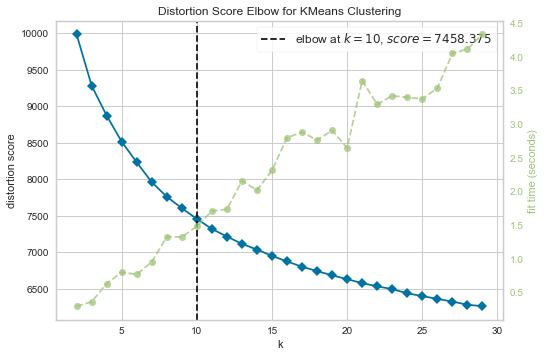

In [21]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(raw_array)        # Fit data to visualizer
visualizer.show() 

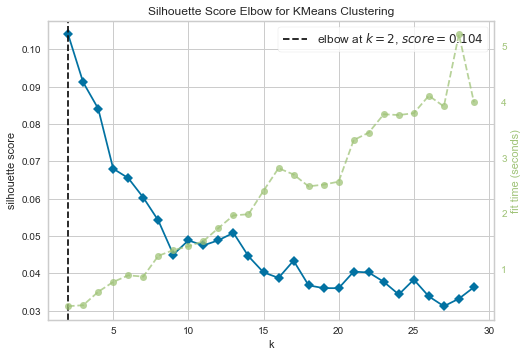

In [22]:
#S(i) close to 0 means that the point is between two clusters
#If it is closer to -1, then we would be better off assigning it to the other clusters
#If S(i) is close to 1, then the point belongs to the ‘correct’ cluster

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(raw_array)        # Fit data to visualizer
visualizer.show() 

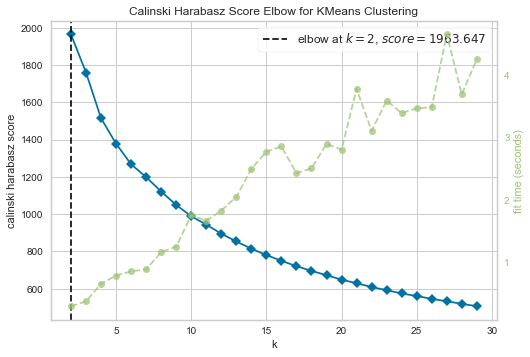

In [23]:
# Higher the Calinski-Harabasz Index value, better the clustering model

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(raw_array)        # Fit data to visualizer
visualizer.show() 

## final model

In [24]:
km1=KMeans(n_clusters=30)
km=km1.fit_predict(raw_array)
lbl=pd.DataFrame(km)
lbl.columns=['Label']
lbl['ct']=1
lbl[:3]

,Label,ct
0,0,1
1,0,1
2,12,1


In [25]:
center=pd.DataFrame(km1.cluster_centers_)
center=center.values
center=np.transpose(center)
center.shape

(102, 30)

In [26]:
center=pd.DataFrame(center)
center['variable']=num_cols

center=center.merge(vbles[['Name','Label']], how='inner',left_on='variable',right_on='Name')
center.to_csv(path+'/03_cluster_center.csv')
center[:4]

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,variable,Name,Label
0,0.210702,0.199199,0.182293,0.199431,0.205359,0.199985,0.194511,0.205602,0.199199,0.372383,...,0.199199,0.201003,0.199662,0.195941,0.199199,0.199199,0.162015,S0102_C01_061E,S0102_C01_061E,"Estimate!!Total!!PLACE OF BIRTH, NATIVITY AND ..."
1,0.088312,0.103082,0.093148,0.102938,0.097784,0.105866,0.091089,0.099530,0.103082,0.099116,...,0.103082,0.103679,0.129360,0.101078,0.103082,0.103082,0.212631,S0102_C01_065E,S0102_C01_065E,Estimate!!Total!!LANGUAGE SPOKEN AT HOME AND A...
2,0.058567,0.088904,0.068404,0.029253,0.067528,0.130636,0.046384,0.034468,0.071699,0.063761,...,0.027175,0.097773,0.885539,0.079101,0.021251,0.034359,0.126322,S1601_C01_004E,S1601_C01_004E,Estimate!!Total!!Population 5 years and over!!...
3,0.027337,0.010117,0.059492,0.006226,0.014234,0.073681,0.046917,0.009993,0.042372,0.021333,...,0.011402,0.012803,0.002058,0.106963,0.005339,0.006115,0.500340,S1601_C01_012E,S1601_C01_012E,Estimate!!Total!!Population 5 years and over!!...


#### center Rank

In [27]:
cr=center.copy()
cr.index=cr['variable']
cr=cr.drop(['Label','Name','variable'],1)
cr=cr.T

for c in list(cr.columns):
    cr[c]=cr[c].rank(ascending=False)
    
cr=cr.T

In [28]:
cr
## each row is ranked between 1 and 30: highest value ranked 1 and lowest value ranked 30

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
variable,,,,,,,,,,,,,,,,,,,,,
S0102_C01_061E,2.0,16.5,28.0,12.0,5.0,9.0,25.0,4.0,16.5,1.0,...,23.0,3.0,16.5,16.5,8.0,10.0,24.0,16.5,16.5,29.0
S0102_C01_065E,30.0,12.5,27.0,17.0,25.0,6.0,29.0,22.0,12.5,24.0,...,7.0,23.0,12.5,12.5,8.0,3.0,19.0,12.5,12.5,2.0
S1601_C01_004E,17.0,9.0,12.0,26.0,13.0,6.0,20.0,24.0,11.0,14.0,...,28.0,21.0,30.0,27.0,8.0,1.0,10.0,29.0,25.0,7.0
S1601_C01_012E,13.0,20.0,8.0,27.0,16.0,6.0,10.0,21.0,11.0,14.0,...,23.0,17.0,25.0,19.0,18.0,30.0,3.0,29.0,28.0,1.0
S0101_C03_001E,27.0,9.0,17.0,10.0,30.0,14.0,26.0,13.0,3.0,29.0,...,12.0,25.0,8.0,11.0,2.0,28.0,5.0,7.0,22.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0101_C05_015E,12.0,18.0,25.0,10.0,17.0,19.0,6.0,11.0,29.0,1.0,...,23.0,3.0,4.0,7.0,20.0,8.0,24.0,14.0,5.0,15.0
S0101_C05_016E,12.0,17.0,26.0,9.0,18.0,20.0,7.0,11.0,30.0,1.0,...,22.0,3.0,4.0,10.0,19.0,6.0,24.0,13.0,5.0,15.0
S0101_C05_017E,11.0,16.0,26.0,10.0,17.0,21.0,7.0,9.0,29.0,1.0,...,20.0,3.0,6.0,13.0,18.0,4.0,25.0,12.0,5.0,14.0


In [29]:
topN=[]
for c in [0]:#list(cr.columns):
    top=cr[[c]].sort_values(c)[[c]][:10]

In [30]:
top

,0
variable,
S2403_C01_022E,1.0
S0102_C01_061E,2.0
S2403_C01_008E,2.0
S0502_C01_025E,2.0
S0102_C01_032E,3.0
S0102_C01_025E,3.0
S0102_C01_069E,3.0
S0101_C05_001E,4.0
S2403_C01_020E,5.0


#### label

In [31]:
lblr=lbl.values

lbl2=pd.concat([zp.reset_index(drop=True),pd.DataFrame(lblr, columns=['Label','ct']).reset_index(drop=True)],axis=1)
lbl2.to_csv(path+'/03_Label.csv',index=False)
lbl2[:3]

,state,zip code tabulation area,S0101_C01_001E,Label,ct
0,54,25303,6764,0,1
1,54,25311,10964,0,1
2,54,25419,11062,12,1


In [32]:
lbl_pct=lbl2.groupby('Label',as_index=False)['ct'].sum().sort_values('ct',ascending=False)
lbl_pct['pct']=lbl_pct['ct']/lbl_pct['ct'].sum()
lbl_pct

,Label,ct,pct
12,12,1473,0.079185
16,16,1395,0.074992
0,0,1381,0.074239
7,7,1155,0.062090
6,6,1023,0.054994
23,23,1004,0.053973
10,10,982,0.052790
21,21,961,0.051661
28,28,877,0.047145
27,27,876,0.047092


### final data to identify cluster features

In [33]:
clusters=lbl2.merge(raw,how='inner',on=gp+[bse])
clusters.shape

(18602, 107)

In [34]:
clusters[:3]

,state,zip code tabulation area,S0101_C01_001E,Label,ct,S0102_C01_061E,S0102_C01_065E,S1601_C01_004E,S1601_C01_012E,S0101_C03_001E,...,S0101_C05_010E,S0101_C05_011E,S0101_C05_012E,S0101_C05_013E,S0101_C05_014E,S0101_C05_015E,S0101_C05_016E,S0101_C05_017E,S0101_C05_018E,S0101_C05_019E
0,54,25303,6764,0,1,NaN,NaN,0.008427,0.014784,0.486694,...,0.031490,0.027055,0.030603,0.029273,0.038734,0.028977,0.034004,0.015819,0.005618,0.009462
1,54,25311,10964,0,1,NaN,NaN,0.007114,0.004469,0.488508,...,0.036848,0.027362,0.029186,0.032835,0.050438,0.023714,0.014593,0.011766,0.011401,0.023076
2,54,25419,11062,12,1,NaN,NaN,0.011481,0.012475,0.510486,...,0.016182,0.044748,0.046737,0.023775,0.021967,0.048183,0.022148,0.014554,0.009040,0.005695


In [35]:
CT=clusters.groupby('Label',as_index=False)['ct'].sum()

In [36]:
num= [x for x in list(clusters.columns) if x not in gp+[bse,'Label','ct']]
cluster_name=CT.merge(clusters.groupby('Label',as_index=False)[num].mean(),on='Label',how='inner')

In [37]:
clusters.to_csv(path+'/03_cluster_output.csv',index=False)
cluster_name.to_csv(path+'/03_cluster_names.csv',index=False)

In [38]:
cluster_name=cluster_name.T

In [39]:
cluster_name=cluster_name.reset_index()
cluster_name

,index,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,Label,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,...,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000
1,ct,1381.000000,630.000000,557.000000,600.000000,571.000000,724.000000,1023.000000,1155.000000,70.000000,...,131.000000,961.000000,783.000000,1004.000000,285.000000,143.000000,276.000000,876.000000,877.000000,172.000000
2,S0102_C01_061E,0.001317,NaN,0.000749,0.001805,0.001390,0.001179,0.001112,0.001590,NaN,...,0.000666,0.001441,NaN,NaN,0.001953,0.001216,0.001069,NaN,NaN,0.000828
3,S0102_C01_065E,0.000123,NaN,0.000102,0.000038,0.000124,0.000226,0.000148,0.000106,NaN,...,0.000346,0.000157,NaN,NaN,0.000316,0.001425,0.000181,NaN,NaN,0.000627
4,S1601_C01_004E,0.057816,0.087775,0.067535,0.028882,0.066671,0.128978,0.045795,0.034030,0.070789,...,0.021610,0.045114,0.020674,0.026830,0.096531,0.874294,0.078096,0.020981,0.033923,0.124718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,S0101_C05_015E,0.029286,0.026155,0.020017,0.030635,0.026408,0.025012,0.033225,0.029888,0.001969,...,0.021112,0.042260,0.038954,0.032454,0.023729,0.031982,0.020234,0.027816,0.034767,0.027347
100,S0101_C05_016E,0.022477,0.020180,0.014688,0.024715,0.019816,0.018397,0.026236,0.023372,0.000610,...,0.016204,0.033038,0.029836,0.023855,0.019011,0.028267,0.015458,0.021646,0.028397,0.020822
101,S0101_C05_017E,0.016709,0.014635,0.009541,0.017407,0.014353,0.012562,0.019213,0.018026,0.000755,...,0.012966,0.024336,0.020288,0.016000,0.014133,0.022024,0.010444,0.016306,0.021673,0.015084
102,S0101_C05_018E,0.012653,0.010182,0.006056,0.011128,0.010642,0.009199,0.014443,0.012761,0.000749,...,0.008333,0.017256,0.013458,0.010243,0.010471,0.015775,0.007743,0.011409,0.014491,0.011559


In [40]:
cluster_name=cluster_name[cluster_name['index']!='Label'].rename(columns={'index':'Name'})
cluster_name=vbles[['Name','Label']].merge(cluster_name,how='inner',on='Name')
cluster_name.to_csv(path+'/03_cluster_names2.csv',index=False)